In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diseases-and-symptoms-dataset/Final_Augmented_dataset_Diseases_and_Symptoms.csv


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df=pd.read_csv('/kaggle/input/diseases-and-symptoms-dataset/Final_Augmented_dataset_Diseases_and_Symptoms.csv')

In [7]:
df.head()

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
columns=df.columns.tolist()

In [9]:
columns


['diseases',
 'anxiety and nervousness',
 'depression',
 'shortness of breath',
 'depressive or psychotic symptoms',
 'sharp chest pain',
 'dizziness',
 'insomnia',
 'abnormal involuntary movements',
 'chest tightness',
 'palpitations',
 'irregular heartbeat',
 'breathing fast',
 'hoarse voice',
 'sore throat',
 'difficulty speaking',
 'cough',
 'nasal congestion',
 'throat swelling',
 'diminished hearing',
 'lump in throat',
 'throat feels tight',
 'difficulty in swallowing',
 'skin swelling',
 'retention of urine',
 'groin mass',
 'leg pain',
 'hip pain',
 'suprapubic pain',
 'blood in stool',
 'lack of growth',
 'emotional symptoms',
 'elbow weakness',
 'back weakness',
 'pus in sputum',
 'symptoms of the scrotum and testes',
 'swelling of scrotum',
 'pain in testicles',
 'flatulence',
 'pus draining from ear',
 'jaundice',
 'mass in scrotum',
 'white discharge from eye',
 'irritable infant',
 'abusing alcohol',
 'fainting',
 'hostile behavior',
 'drug abuse',
 'sharp abdominal pain

In [10]:
df.isnull()

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246940,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246941,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246942,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246943,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
df.isnull().sum()

diseases                            0
anxiety and nervousness             0
depression                          0
shortness of breath                 0
depressive or psychotic symptoms    0
                                   ..
hip weakness                        0
back swelling                       0
ankle stiffness or tightness        0
ankle weakness                      0
neck weakness                       0
Length: 378, dtype: int64

In [12]:
#JUST IN CASE IF THERE IS ANY MISSING VALUE

In [13]:
df.fillna(0,inplace=True)

In [14]:
X = df.iloc[:, 1:]  # Symptoms (columns after 'diseases')
y = df["diseases"]  # Disease labels

DATA VISUALIZATION

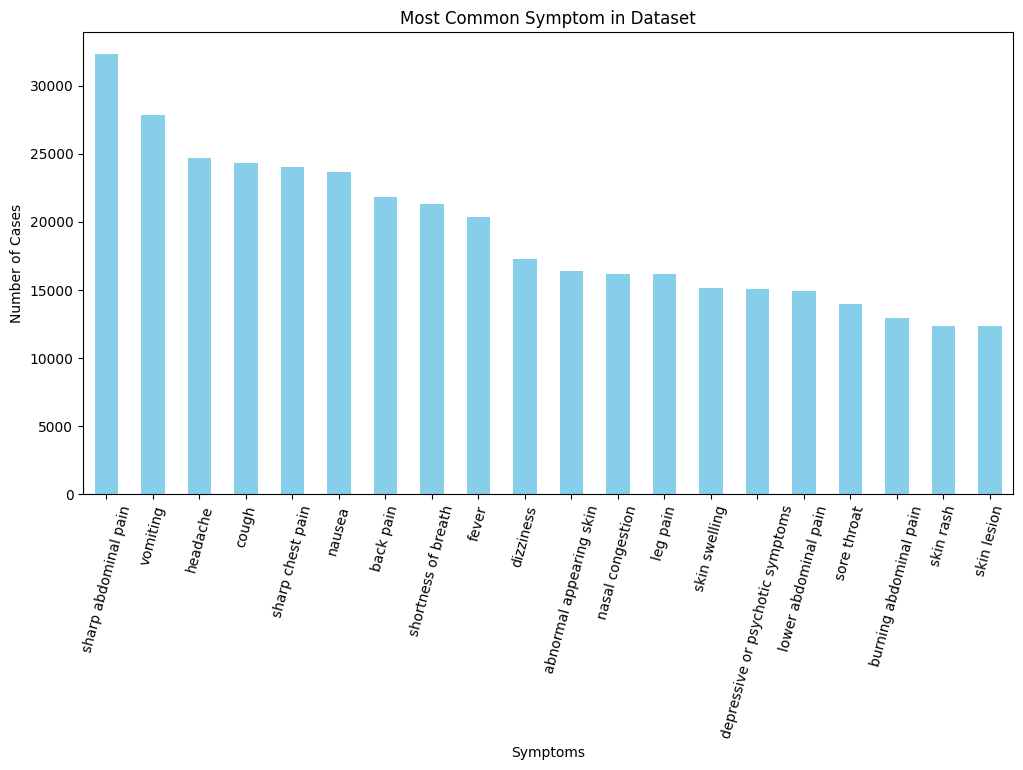

In [15]:
#sum across all rows(patients) to get total count per symtom

symptom_count = X.sum().sort_values(ascending=False)[:20]  #top 20 symptoms

plt.figure(figsize=(12,6))
symptom_count.plot(kind='bar',color='skyblue')
plt.title("Most Common Symptom in Dataset")
plt.xlabel("Symptoms")
plt.ylabel("Number of Cases")
plt.xticks(rotation=75)
plt.show()

this above graph shows the symtom that has occured most in data set not the most common symptom

Disease Frequency Distribution( shows which disease is **most common** in Dataset)

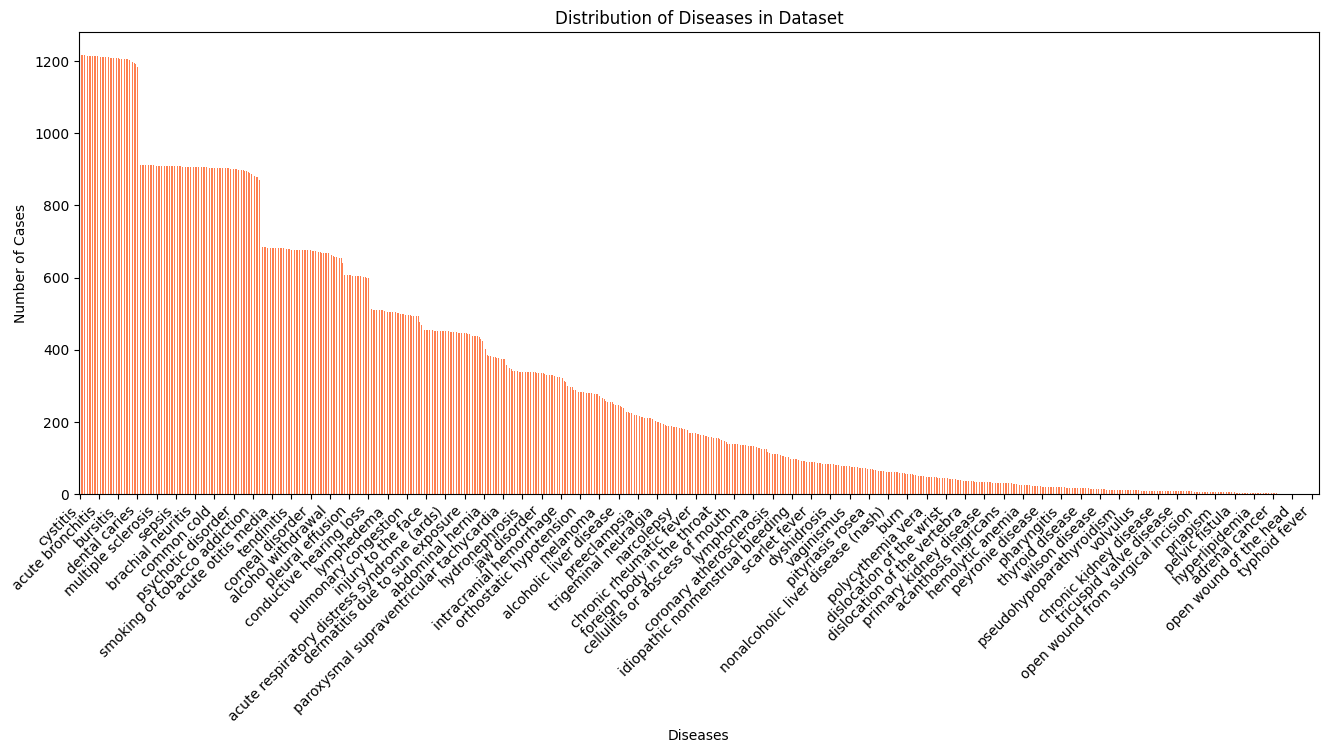

In [16]:
plt.figure(figsize=(16, 6))
df["diseases"].value_counts().plot(kind='bar', color='coral')
plt.title("Distribution of Diseases in Dataset")
plt.xlabel("Diseases")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45,ha='right')

# Show every 12th label on the x-axis
ax = plt.gca()
ax.set_xticks(ax.get_xticks()[::12])  # Show every 12th label
plt.xticks(rotation=45, ha='right')  # Rotate labels by 45° and align them
plt.show()

 **SYMPTOMS CO-OCCURENCE HEATMAP**  

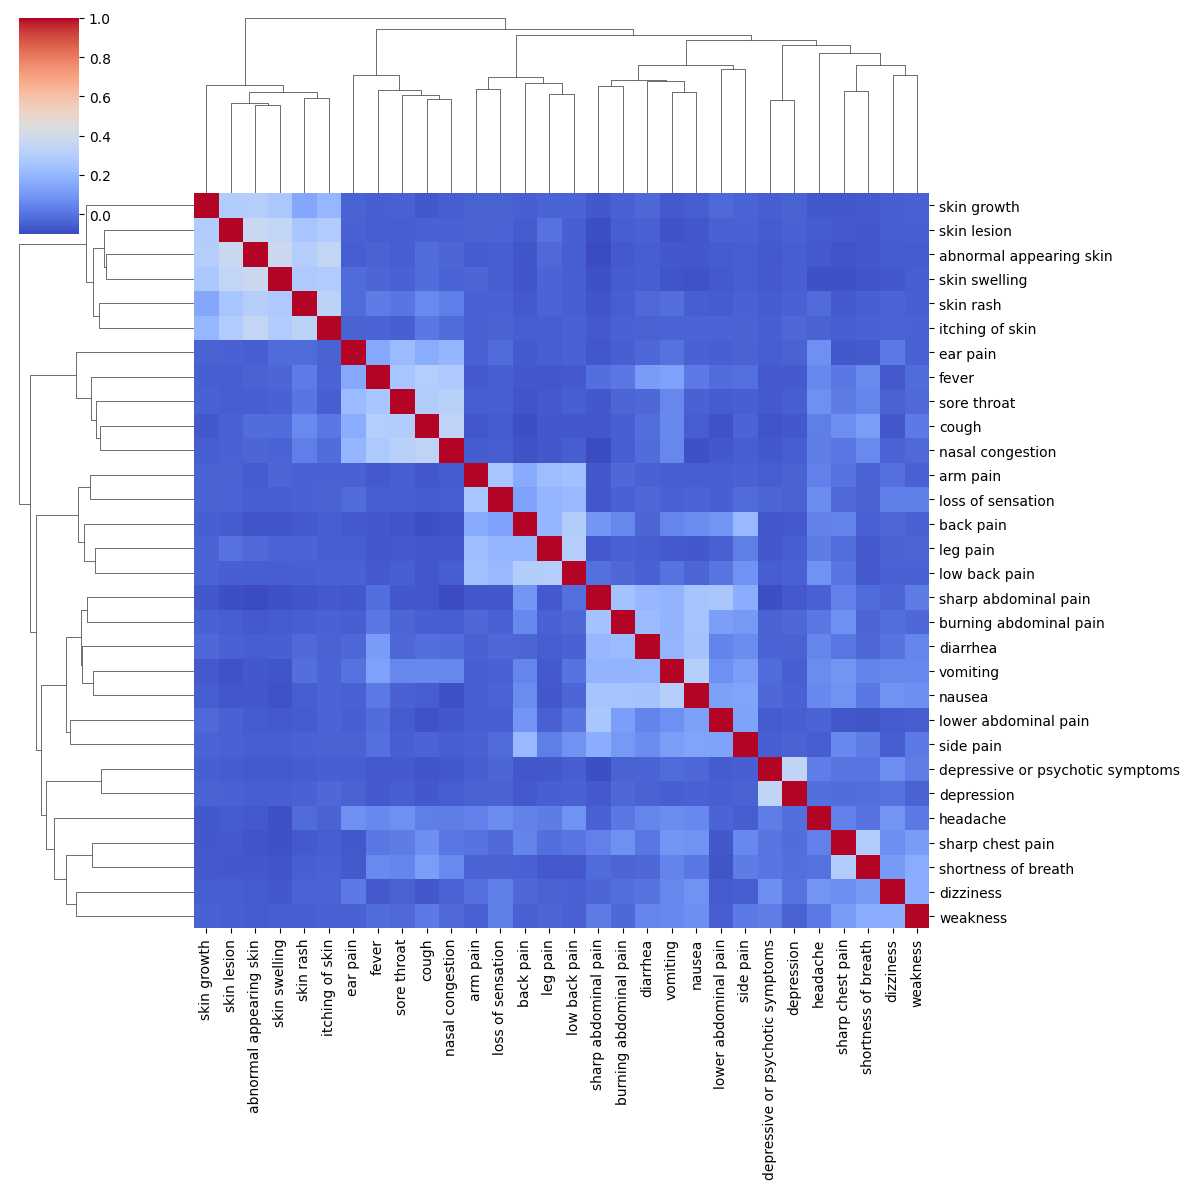

In [17]:

top_symptoms = X.sum().sort_values(ascending=False).head(30).index
sns.clustermap(X[top_symptoms].corr(), cmap="coolwarm", figsize=(12, 12))

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


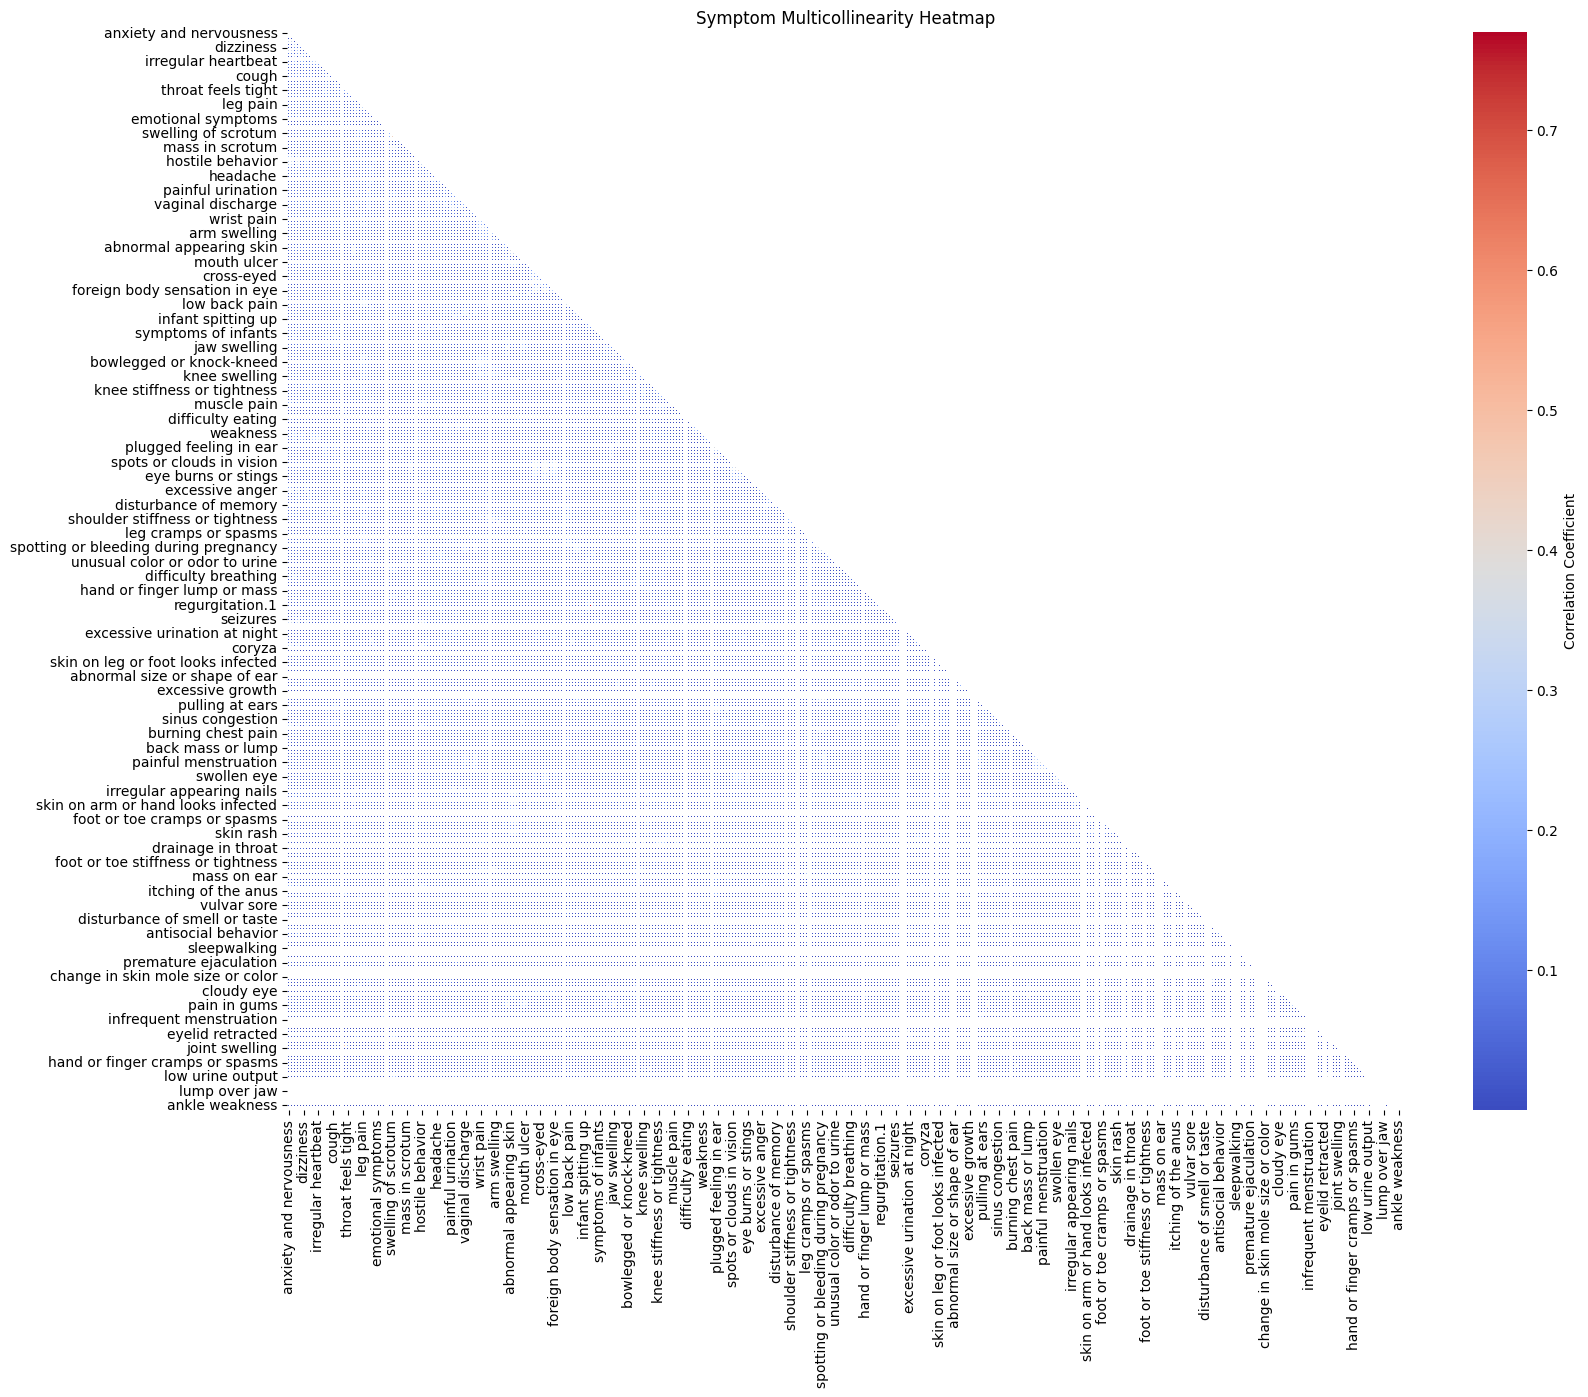

In [18]:
# Assuming `df` is your dataframe and 'diseases' is the target column
symptom_data = df.drop('diseases', axis=1)

# Compute correlation matrix
corr_matrix = symptom_data.corr().abs()  # Absolute value to see strength only

# Mask lower triangle and self-correlation for cleaner visualization
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', linewidths=0.1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Symptom Multicollinearity Heatmap')
plt.show()